In [1]:
import random

import torch
import torch.nn as nn
from cmws import util
import torch
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    HardPhongShader,
    TexturesUV,
    TexturesVertex,
    BlendParams,
    softmax_rgb_blend
)
from pytorch3d.structures.meshes import (
    Meshes,
    join_meshes_as_batch,
    join_meshes_as_scene,
)
import numpy as np
from cmws.examples.stacking_3d import data, render
from cmws import util
import matplotlib.pyplot as plt

device = 'cpu'

In [2]:
num_primitives = 3
primitives = [
    render.Cube(
        "A", torch.tensor([1.0, 0.0, 0.0], device=device), torch.tensor(0.3, device=device)
    ),
    render.Cube(
        "B", torch.tensor([0.0, 1.0, 0.0], device=device), torch.tensor(0.4, device=device)
    ),
    render.Cube(
        "C", torch.tensor([0.0, 0.0, 1.0], device=device), torch.tensor(0.5, device=device)
    ),
][:num_primitives]
# num_primitives = len(primitives)

# Sample
stacking_program = data.sample_stacking_program(
    num_primitives, device, fixed_num_blocks=False
)
raw_locations = data.sample_raw_locations(stacking_program)

In [3]:
im_size = 32

shape = stacking_program.shape[:-1]
max_num_blocks = stacking_program.shape[-1]
num_elements = util.get_num_elements(shape)
num_channels = 3
num_blocks = torch.tensor(len(stacking_program), device=device).long()

# [num_primitives]
square_size = torch.stack([primitive.size for primitive in primitives])
# [num_primitives, 3]
square_color = torch.stack([primitive.color for primitive in primitives])

# Convert [*shape, max_num_blocks, 3]
locations = render.convert_raw_locations_batched(raw_locations, stacking_program, primitives)

# Flatten
num_blocks_flattened = num_blocks.reshape(num_elements)
stacking_program_flattened = stacking_program.reshape((num_elements, max_num_blocks))
locations_flattened = locations.view((num_elements, max_num_blocks, 3))

imgs = render.render_cubes(num_blocks_flattened, square_size[stacking_program_flattened], square_color[stacking_program_flattened], locations_flattened, im_size)
imgs = imgs.permute(0, 3, 1, 2)
imgs = imgs.view(*[*shape, num_channels, *imgs.shape[-2:]])

In [4]:
num_cubes = num_blocks_flattened
sizes = square_size[stacking_program_flattened]
colors = square_color[stacking_program_flattened]
positions = locations_flattened

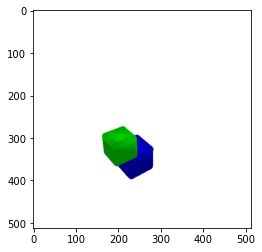

In [33]:

im_size = 512

# Create camera

rot_angle = [rot for rot in np.linspace(0, 360, 10, endpoint=False)]
imgs = []

for rot in rot_angle: 

    R, T = look_at_view_transform(3.7, 30, rot + 180, at=((-0.1, 0.0, 0.1),),)
    # R, T = look_at_view_transform(3.7, 0.1, 180, at=((-0.15, 0.0, 0.1),),)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T,
                                    )#fov=90.0)  # fov=45.0)

    # Settings for rasterizer (optional blur)
    # 
    blend_params = BlendParams( sigma = 1e-4, gamma = 1e-4)
    raster_settings = RasterizationSettings(
        image_size=im_size, # crisper objects + texture w/ higher resolution
        blur_radius = np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
        faces_per_pixel=2, # increase at cost of GPU memory,
        bin_size=0
    )

    # Add light from the front
    lights = PointLights(device=device, location=[[0.0, 3.0, 0.0]]) # top light

    # Compose renderer and shader
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device,
            cameras=cameras,
            lights=lights,
            blend_params=blend_params
        )
    )

    # create one mesh per elmt in batch

    meshes = []
    for batch_idx, n_cubes in enumerate(num_cubes):
        # Combine obj meshes into single mesh from rendering
        # https://github.com/facebookresearch/pytorch3d/issues/15
        vertices = []
        faces = []
        textures = []
        vert_offset = 0 # offset by vertices from prior meshes
        for i, (position, size,color) in enumerate(zip(positions[batch_idx, :n_cubes, :], sizes[batch_idx, :n_cubes],
                                                       colors[batch_idx, :n_cubes, :])):
            cube_vertices, cube_faces = render.get_cube_mesh(position, size)
            # For now, apply same color to each mesh vertex (v \in V)
            texture = torch.ones_like(cube_vertices) * color# [V, 3]
            # Offset faces (account for diff indexing, b/c treating as one mesh)
            cube_faces = cube_faces + vert_offset
            vert_offset = cube_vertices.shape[0]
            vertices.append(cube_vertices)
            faces.append(cube_faces)
            textures.append(texture)

        # Concatenate data into single mesh
        vertices = torch.cat(vertices)
        faces = torch.cat(faces)
        textures = torch.cat(textures)[None]  # (1, num_verts, 3)
        textures = TexturesVertex(verts_features=textures)
        # each elmt of verts array is diff mesh in batch
        mesh = Meshes(verts=[vertices], faces=[faces], textures=textures)
        meshes.append(mesh)

    batched_mesh = join_meshes_as_batch(meshes)

    # Render image
    img = renderer(batched_mesh)   # (B, H, W, 4)

    # Remove alpha channel and return (B, im_size, im_size, 3)
    img = img[:, ..., :3]#.detach().squeeze().cpu().numpy()
    imgs.append(img[0])
    plt.imshow(img[0])
    #plt.axis('off')

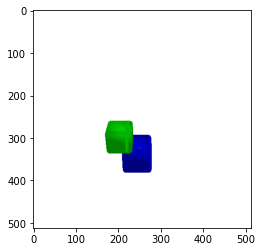

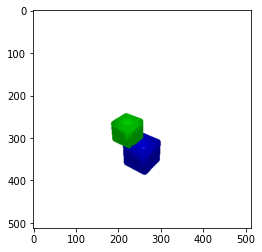

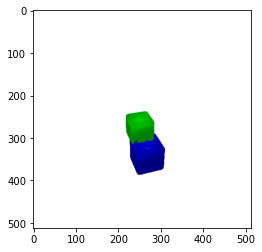

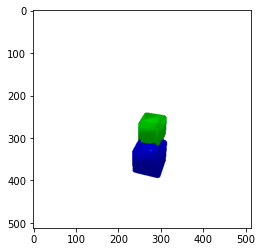

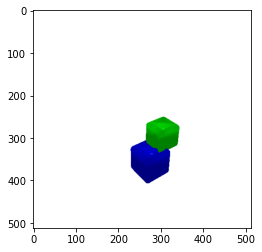

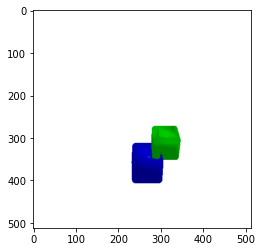

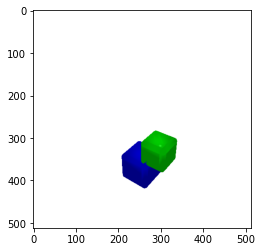

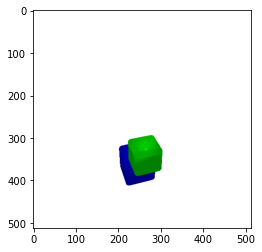

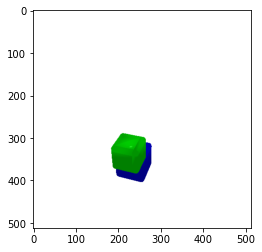

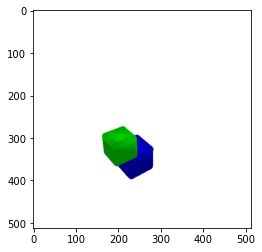

In [35]:
for rot, img in zip(rot_angle, imgs): 
    plt.figure()
    plt.imshow(img)
    plt.savefig(f"./rotate_camera/rot_{rot}.png")

In [28]:
np.linspace(0, 360, 10, endpoint=False)

array([  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162.])